In [1]:
import os
import torch
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
# import wget

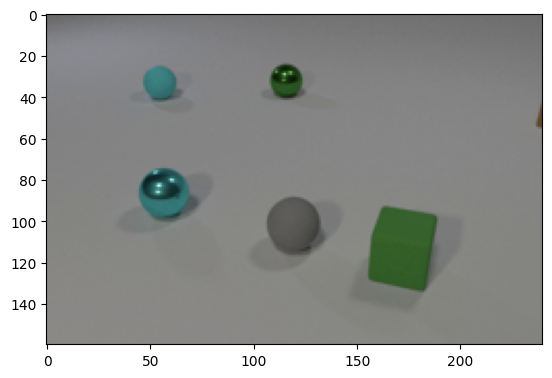

In [19]:
vid0img0 = "Dataset_Student/train/video_0/image_0.png"
plt.imshow(iio.imread(vid0img0 ))

In [4]:
mask = np.load("Dataset_Student/train/video_0/mask.npy")
print(mask.shape)

(22, 160, 240)


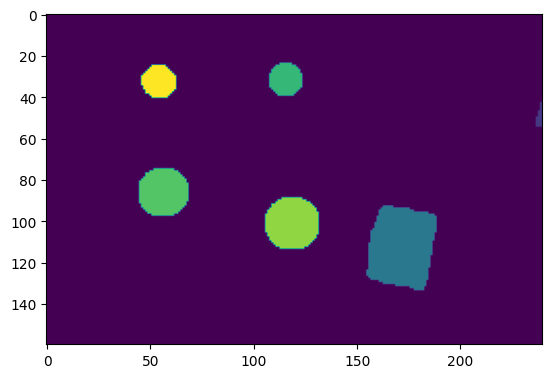

In [8]:
plt.imshow(mask[0])

### Download Data

In [20]:
# wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

### Import Dependencies

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data and Create Dataloaders

In [22]:
from PIL import Image
import torch
from torchvision import transforms

# Load the PNG image using PIL (Python Imaging Library)
image_path = 'Dataset_Student/train/video_0/image_0.png'
image = Image.open(image_path)

# Define a torchvision transform to convert the image to a PyTorch tensor
transform = transforms.ToTensor()

# Apply the transform to the image
tensor_image = transform(image)

# Print the shape of the resulting tensor
print(tensor_image.shape)


torch.Size([3, 160, 240])


In [10]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
# np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_test_seq.npy'

### Visualize Data

In [4]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

### Instantiate Model, Optimizer and Loss

In [5]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

### Train for about 20 epochs

In [6]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))

Epoch:1 Training Loss:357.56 Validation Loss:304.39

Epoch:2 Training Loss:298.88 Validation Loss:295.64

Epoch:3 Training Loss:289.45 Validation Loss:286.25

Epoch:4 Training Loss:282.47 Validation Loss:286.29

Epoch:5 Training Loss:275.04 Validation Loss:272.63

Epoch:6 Training Loss:270.13 Validation Loss:265.76

Epoch:7 Training Loss:264.20 Validation Loss:265.78

Epoch:8 Training Loss:259.36 Validation Loss:256.29

Epoch:9 Training Loss:256.57 Validation Loss:254.94

Epoch:10 Training Loss:252.14 Validation Loss:253.47

Epoch:11 Training Loss:248.08 Validation Loss:249.52

Epoch:12 Training Loss:247.46 Validation Loss:241.73

Epoch:13 Training Loss:244.14 Validation Loss:240.97

Epoch:14 Training Loss:241.95 Validation Loss:240.79

Epoch:15 Training Loss:239.33 Validation Loss:239.73

Epoch:16 Training Loss:237.88 Validation Loss:236.23

Epoch:17 Training Loss:236.22 Validation Loss:234.94

Epoch:18 Training Loss:234.75 Validation Loss:236.16

Epoch:19 Training Loss:231.63 Validat

### Visualize what our model has learned so far

In [7]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,10:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+10]   
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [8]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))